In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from matplotlib.patches import Patch

In [61]:
image_path = '/projectnb/ec500kb/projects/Project_4/PROJECT_DATA/training/001.generation.tif'
image = plt.imread(image_path)
orig_image = plt.imread(image_path)

mask_path = '/projectnb/ec500kb/projects/Project_4/PROJECT_DATA/training/001.segmentation.tif'
mask = plt.imread(mask_path)

label_path = '//projectnb/ec500kb/projects/Project_4/PROJECT_DATA/label_list_target.txt'
label_name_map = {}

with open(label_path, 'r') as file:
    for line in file:
        index, label_name = line.strip().split(' ', 1)
        index = int(index)
        label_name_map[index] = label_name

{2: (102, 179, 92), 3: (14, 106, 71), 4: (188, 20, 102), 10: (121, 210, 214), 12: (74, 202, 87), 13: (116, 99, 103), 17: (151, 130, 149), 28: (52, 1, 87), 41: (235, 157, 37), 42: (129, 191, 187), 43: (20, 160, 203), 49: (57, 21, 252), 51: (235, 88, 48), 52: (218, 58, 254), 53: (169, 255, 219), 60: (187, 207, 14)}


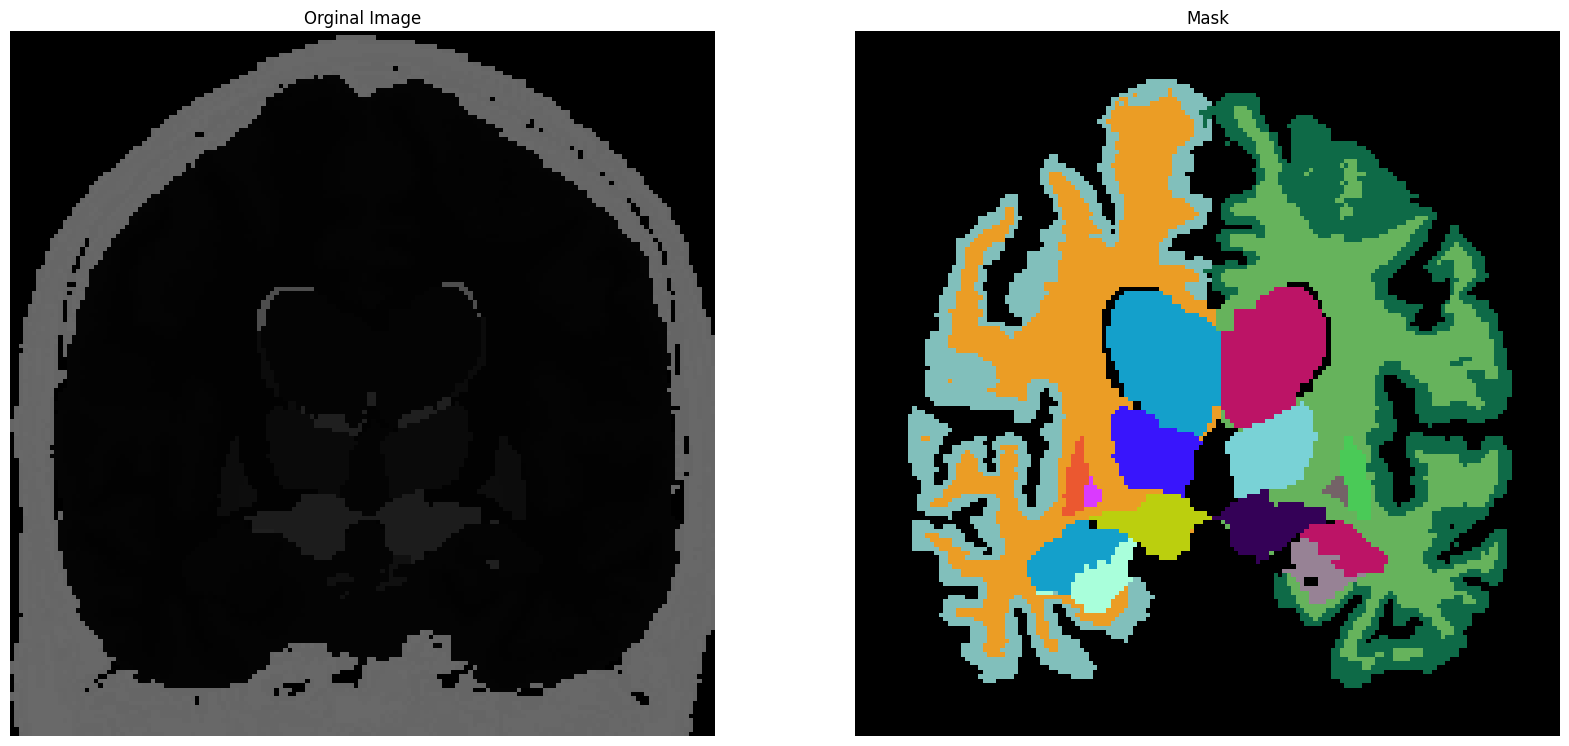

In [3]:
#create a color map for visualization 
np.random.seed(42)
label_color_map = {label: tuple(np.random.choice(range(256), size=3)) for label in label_name_map.keys()}

print(label_color_map)

height, width = 160, 160 
labels = np.random.choice(list(label_name_map.keys()), size=(height, width))  # Random labels for demonstration

color_image = np.zeros((height, width, 3), dtype=np.uint8)
for label, color in label_color_map.items():
    color_image[labels == label] = color


legend_patches = [Patch(color=np.array(color)/255.0, label=name) for label, name in label_name_map.items()]

mask_height, mask_width = mask.shape[:2]
color_mask = np.zeros((mask_height, mask_width, 3), dtype=np.uint8)
for label, color in label_color_map.items():
    color_mask[mask == label] = color

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Orginal Image')
ax1.axis('off')

plt.imshow(color_mask)
ax2.set_title('Mask')
ax2.axis('off')

plt.show()

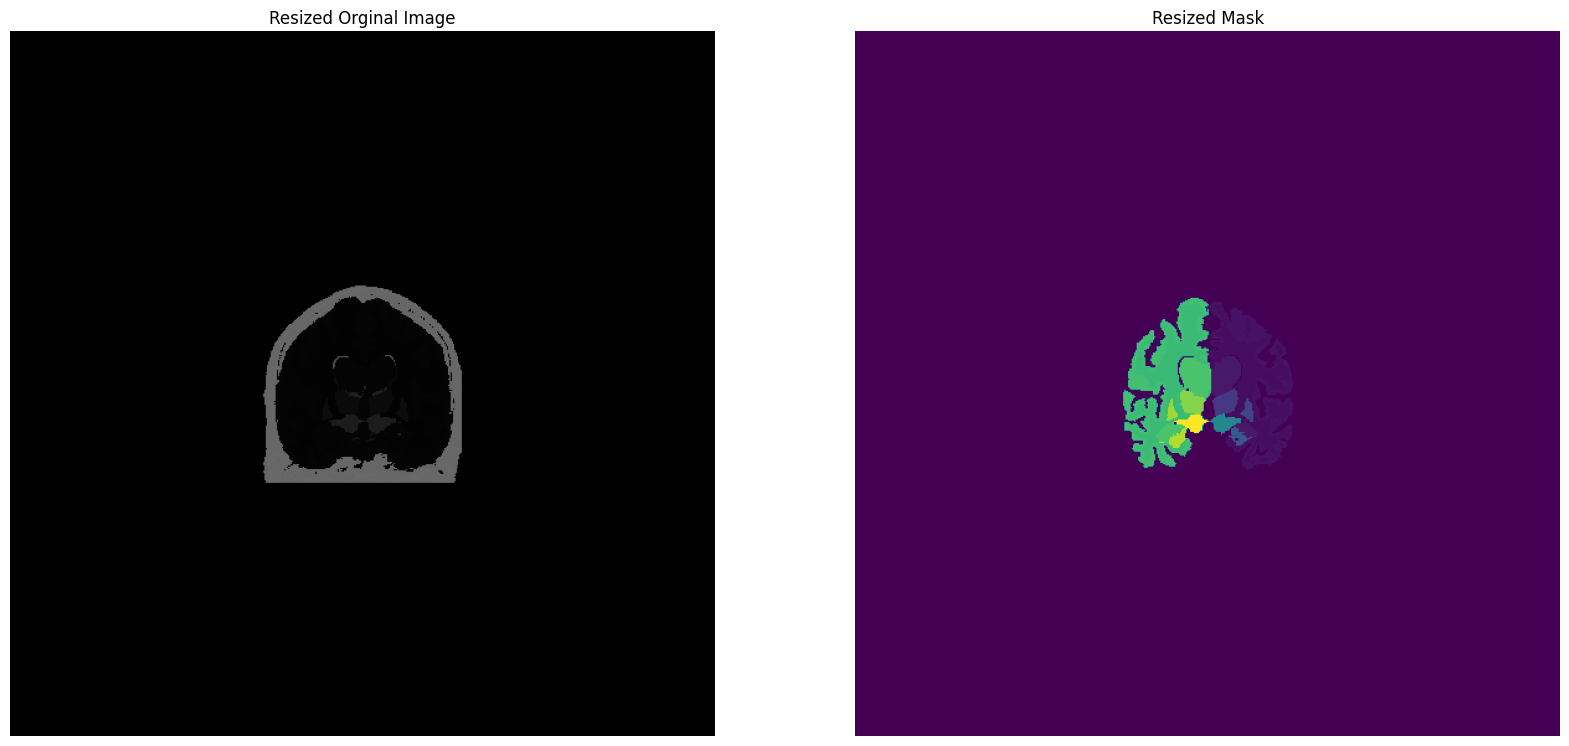

In [4]:
# add padding 
target_size = 568 #input of UNET change? 

padding_height = (target_size - image.shape[0]) // 2
padding_width = (target_size - image.shape[1]) // 2

extra_pad_height = (target_size - image.shape[0]) % 2
extra_pad_width = (target_size - image.shape[1]) % 2

image = np.pad(image,
                      ((padding_height, padding_height + extra_pad_height),
                       (padding_width, padding_width + extra_pad_width)),
                      mode='constant', constant_values=0)
mask = np.pad(mask,
                      ((padding_height, padding_height + extra_pad_height),
                       (padding_width, padding_width + extra_pad_width)),
                      mode='constant', constant_values=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image, cmap='gray', vmin=0, vmax=255)
ax1.set_title('Resized Orginal Image')
ax1.axis('off')

plt.imshow(mask)
ax2.set_title('Resized Mask')
ax2.axis('off')

plt.show()

In [34]:
def adjust_and_concat(x_enc, x_dec):
    _, _, H_enc, W_enc = x_enc.size()
    _, _, H_dec, W_dec = x_dec.size()

    # determine if we need to pad or crop
    pad_H = max(H_enc - H_dec, 0)
    pad_W = max(W_enc - W_dec, 0)
    crop_H = max(H_dec - H_enc, 0)
    crop_W = max(W_dec - W_enc, 0)

    # apply padding/crop if necessary
    if pad_H > 0 or pad_W > 0:
        x_dec = F.pad(x_dec, pad=(0, pad_W, 0, pad_H), mode='constant', value=0)

    if crop_H > 0 or crop_W > 0:
        x_dec = x_dec[:, :, crop_H // 2:-crop_H // 2, crop_W // 2:-crop_W // 2]

    # Concatenate along the channel dimension
    return torch.cat([x_enc, x_dec], dim=1)

class UNet(nn.Module):
    def __init__(self, n_class, in_channels=1):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1)


    def forward(self, x):

        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)
        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = adjust_and_concat(xe42, xu1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = adjust_and_concat(xu2, xe32)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = adjust_and_concat(xu3, xe22)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = adjust_and_concat(xu4, xe12)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = F.softmax(out, dim=1)

        return out

In [52]:
# remap classing for training 
class_mapping = {
    2: 0,
    3: 1,
    4: 2,
    10: 3,
    12: 4,
    13: 5,
    17: 6,
    28: 7,
    41: 8,
    42: 9,
    43: 10,
    49: 11,
    51: 12,
    52: 13,
    53: 14,
    60: 15
}


def remap_classes(mask, class_mapping):
    remapped_mask = np.zeros_like(mask)
    for original, new in class_mapping.items():
        remapped_mask[mask == original] = new
    return remapped_mask


mask_remapped = remap_classes(mask, class_mapping)


image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_remapped, dtype=torch.float32).unsqueeze(0)

In [53]:
mask_tensor.shape

torch.Size([1, 568, 568])

In [54]:
dataset = TensorDataset(image_tensor, mask_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = UNet(n_class=16, in_channels=1) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# loss Function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = Adam(model.parameters(), lr=.001)

loss_values = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for batch in dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        #resize target
        targets = targets.unsqueeze(0)
        targets = targets.repeat(1, 16, 1, 1)

        outputs = model(inputs)
        print(targets.shape)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_values.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

torch.Size([1, 16, 568, 568])
Epoch 1/10, Loss: 8.602628707885742
torch.Size([1, 16, 568, 568])
Epoch 2/10, Loss: 8.602578163146973
torch.Size([1, 16, 568, 568])
Epoch 3/10, Loss: 8.602556228637695
torch.Size([1, 16, 568, 568])
Epoch 4/10, Loss: 8.602551460266113
torch.Size([1, 16, 568, 568])
Epoch 5/10, Loss: 8.602548599243164
torch.Size([1, 16, 568, 568])
Epoch 6/10, Loss: 8.602544784545898
torch.Size([1, 16, 568, 568])
Epoch 7/10, Loss: 8.602542877197266
torch.Size([1, 16, 568, 568])
Epoch 8/10, Loss: 8.60254192352295
torch.Size([1, 16, 568, 568])
Epoch 9/10, Loss: 8.602540016174316
torch.Size([1, 16, 568, 568])
Epoch 10/10, Loss: 8.6025390625


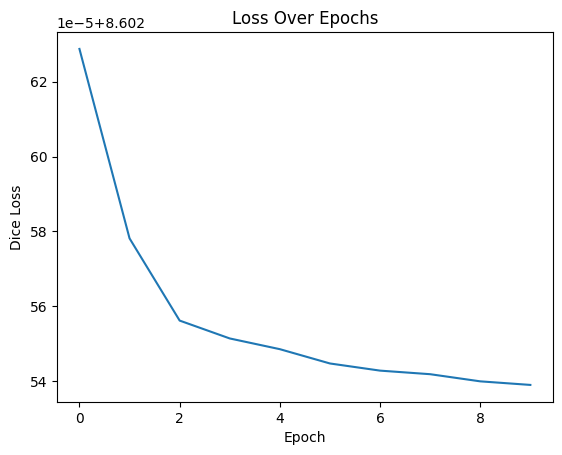

In [55]:
#Plot Loss 
plt.plot(loss_values)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

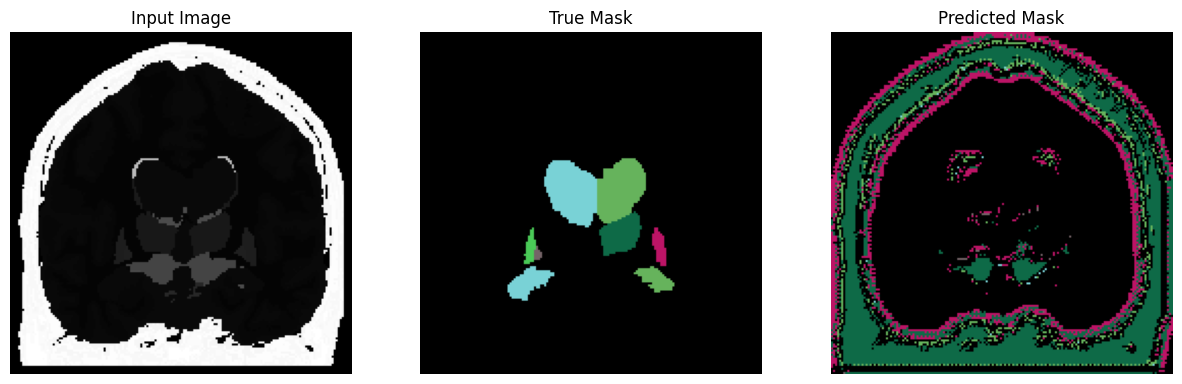

In [69]:
model.eval()

with torch.no_grad(): 
    for inputs, true_masks in dataloader:
        inputs = inputs.to(device)  
        predictions = model(inputs)
        _, predicted_masks = torch.max(predictions, 1)  

input_image = inputs[0].cpu().numpy().squeeze()  
true_mask = true_masks[0].cpu().numpy().squeeze()
predicted_mask = predicted_masks[0].cpu().numpy().squeeze()

# remove padding 
input_image = input_image[200:-200, 200:-200]
true_mask = true_mask[200:-200, 200:-200]
predicted_mask = predicted_mask[200:-200, 200:-200]

# add color map 
color_true_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)
color_predicted_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

for label, color in label_color_map.items():
    color_true_mask[true_mask == label] = color
    color_predicted_mask[predicted_mask == label] = color

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(input_image, cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(color_true_mask)
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(color_predicted_mask)
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()
